In [4]:
cd ../../

/mnt/sda/otani/Experiments/moment_retrieval


In [2]:
%matplotlib inline
from skvideo.io import vread, vwrite
from typing import List
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token, _load_top_actions
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class, predict
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import Charade2Instances
from src.toolbox.baseline import SegmentGeneratorKDE
import seaborn as sns
sns.set_style("white")

/home/otani_mayu/miniconda3/envs/moment_retrieval/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [5]:
train_data = Charade2Instances(pd.read_csv('data/processed/train.csv'))
top_actions = []
with open('data/processed/charade/top50_actions') as f:
    for line in f:
        top_actions.append(line.rstrip())

In [17]:
from collections import Counter
verbs = sum([sentence2token(query[1])[0] for query, _ in train_data], [])
verb_c = Counter(verbs)


In [19]:
top_actions = top_actions[:30]
grouped_instances = {action: [] for action in top_actions}
grouped_instances['base'] = []
for query, location in train_data:
    verb, obj = sentence2token(query[1])
    if len(verb) > 0:
        verb = verb[0]
    else:
        verb = None
    if verb in top_actions:
        grouped_instances[verb].append((query, location))
    else:
        grouped_instances['base'].append((query, location))

In [20]:
segment_generator = SegmentGeneratorKDE()
for action, train_instances in grouped_instances.items():
    print(action)
    segment_generator.fit(action, train_instances)

open
#instances: 1316
put
#instances: 1092
eat
#instances: 656
take
#instances: 823
close
#instances: 764
sit
#instances: 745
hold
#instances: 393
turn
#instances: 510
throw
#instances: 483
run
#instances: 465
drink
#instances: 389
start
#instances: 399
begin
#instances: 383
walk
#instances: 351
look
#instances: 243
sneeze
#instances: 155
laugh
#instances: 198
pour
#instances: 239
smile
#instances: 185
stand
#instances: 226
undress
#instances: 135
cook
#instances: 140
watch
#instances: 122
awaken
#instances: 160
wash
#instances: 122
dress
#instances: 72
play
#instances: 76
read
#instances: 61
fix
#instances: 82
snuggle
#instances: 58
base
#instances: 1365


In [130]:
random.choice(train_data)

'person examining it with a light.'

In [211]:
len(train_data[::10])

1241

In [283]:
import random
pos_mags = []
neg_mags = []

# sub_train = train_data[::100]
# for query, location in sub_train:
query, location = random.choice(train_data)
video_id = query[0]
moments = [location for query, location in train_data if query[0]==video_id]
duration = moments[0][-1]
locations = np.asarray([(s, e) for s, e, _ in moments])

vid_arr = vread(f'data/raw/video/{video_id}.mp4',
                outputdict={"-r": "10", '-vf':'hue=s=0', '-s': '255x255'})
vid_arr = vid_arr[:,:,:,0]
diff = np.power(vid_arr[:-1] - vid_arr[1:], 2)
mag_diff = np.mean(diff, axis=(1,2))
w = np.ones(10)
k = w/w.sum()
mag_diff = np.convolve(k, mag_diff, mode='same')

locations_on_frame = locations / duration * len(vid_arr)
locations_on_frame = np.round(locations_on_frame).astype('i')

pos_mags += [np.mean(mag_diff[s:e]) for s, e in locations_on_frame]
mag_diff_copy = mag_diff.copy()
for s, e in locations_on_frame:
    mag_diff_copy[s:e] = np.nan
neg_mags.append(np.nanmean(mag_diff_copy))

if len(neg_mags)%10==0:
    print(len(neg_mags))

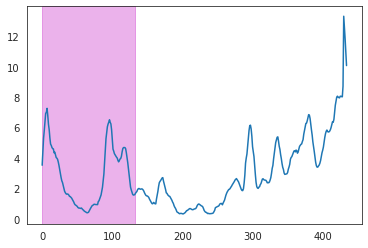

In [284]:
plt.plot(mag_diff)
for loc in locations_on_frame:
    plt.axvspan(*loc, alpha=0.3, color="m")

# Test action prior + motion thresholding

In [223]:
test_data = Charade2Instances(pd.read_csv("data/processed/test.csv"))

In [226]:
diffs = {}

for query, location in test_data:
    video_id = query[0]
    if video_id in diffs:
        continue
        
    moments = [location for query, location in test_data if query[0]==video_id]
    duration = moments[0][-1]
    locations = np.asarray([(s, e) for s, e, _ in moments])

    vid_arr = vread(f'data/raw/video/{video_id}.mp4',
                    outputdict={"-r": "10", '-vf':'hue=s=0', '-s': '255x255'})
    vid_arr = vid_arr[:,:,:,0]
    diff = np.power(vid_arr[:-1] - vid_arr[1:], 2)
    mag_diff = np.mean(diff, axis=(1,2))
    w = np.ones(10)
    k = w/w.sum()
    mag_diff = np.convolve(k, mag_diff, mode='same')
    diffs[video_id] = mag_diff

In [243]:
def get_diff_val(video_id, bboxes):
    diff = diffs[video_id]
    n = len(diff)
    scaled_bboxes = np.round(bboxes * n).astype('i')
    segment_diff = [np.mean(diff[s:e]) for s, e in scaled_bboxes]
    return np.asarray(segment_diff) / 100

def predict(
    segment_generator,
    instances,
    nms_threshold = 0.45,
    top_k = 10,
):
    predictions = []
    for instance in instances:
        query, location = instance
        length = location[-1]
        vide_id = query[0]
        actions, objects = sentence2token(query[1])

        if len(actions):
            actions = [
                action
                for action in actions
                if action in segment_generator.vocab
            ]
            action = actions[0] if len(actions) else "base"
            samples, likelifood = segment_generator.sample(action, 100)
        else:
            samples, likelifood = segment_generator.sample("base", 100)

        bbox = samples.copy()
        bbox[:, 1] = bbox.sum(axis=1)

        valid = (bbox[:, 1] - bbox[:, 0]) > 0
        bbox = bbox[valid]
        likelifood = likelifood[valid]
        diff = get_diff_val(video_id, bbox)
        likelifood += 2*diff

        keep = _nms(bbox, likelifood, nms_threshold, top_k=top_k)
        bbox = bbox[keep]
        likelifood = likelifood[keep]

        location = np.hstack([bbox * length, np.ones((len(bbox), 1)) * length])

        predictions.append((query, location.tolist(), likelifood.tolist()))

    return predictions

In [244]:
predictions = predict(segment_generator, test_data, 0.45, 5)
results = evaluate(test_data, predictions)
summary = accumulate_metrics(results)

R@1 IoU>0.3 0.41
R@1 IoU>0.5 0.27
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.72
R@5 IoU>0.7 0.37
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.72
R@10 IoU>0.7 0.37
